# Vowpal Wabbit and LightGBM for a Regression Problem

This notebook shows how to build simple regression models by using 
[Vowpal Wabbit (VW)](https://github.com/VowpalWabbit/vowpal_wabbit) and 
[LightGBM](https://github.com/microsoft/LightGBM) with MMLSpark.
 We also compare the results with 
 [Spark MLlib Linear Regression](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression).

In [0]:
import math
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from mmlspark.train import ComputeModelStatistics
from mmlspark.vw import VowpalWabbitRegressor, VowpalWabbitFeaturizer
from mmlspark.lightgbm import LightGBMRegressor
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from sklearn.datasets import load_boston

## Prepare Dataset
We use [*Boston house price* dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) 
. 
The data was collected in 1978 from Boston area and consists of 506 entries with 14 features including the value of homes. 
We use `sklearn.datasets` module to download it easily, then split the set into training and testing by 75/25.

In [0]:
boston.data

Out[3]: array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
 4.9800e+00],
 [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
 9.1400e+00],
 [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
 4.0300e+00],
 ...,
 [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
 5.6400e+00],
 [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
 6.4800e+00],
 [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
 7.8800e+00]])

In [0]:
boston.target

Out[4]: array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
 18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
 15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
 13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
 21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
 35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
 19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
 20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
 23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
 33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
 21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
 20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
 23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
 15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21.5, 19.6, 15.3, 19.4,
 17. , 15.6, 13.1, 41.3, 24.3, 23.3, 27. , 50. , 50. , 50. , 22.7,
 25. , 50. , 23.8, 23.8, 22.3, 17.4, 19.1, 23.1, 23.6, 22.6, 29.4,
 23.2, 24.6, 29.9, 37.2, 39.8, 36.2, 37.9, 32.5, 26.4, 29.6, 50. ,
 32. , 29.8, 34.9, 37. , 30.5, 36.4, 31.1, 29.1, 50. , 33.3, 30.3,
 34.6, 34.9, 32.9, 24.1, 42.3, 48.5, 50. , 22.6, 24.4, 22.5, 24.4,
 20. , 21.7, 19.3, 22.4, 28.1, 23.7, 25. , 23.3, 28.7, 21.5, 23. ,
 26.7, 21.7, 27.5, 30.1, 44.8, 50. , 37.6, 31.6, 46.7, 31.5, 24.3,
 31.7, 41.7, 48.3, 29. , 24. , 25.1, 31.5, 23.7, 23.3, 22. , 20.1,
 22.2, 23.7, 17.6, 18.5, 24.3, 20.5, 24.5, 26.2, 24.4, 24.8, 29.6,
 42.8, 21.9, 20.9, 44. , 50. , 36. , 30.1, 33.8, 43.1, 48.8, 31. ,
 36.5, 22.8, 30.7, 50. , 43.5, 20.7, 21.1, 25.2, 24.4, 35.2, 32.4,
 32. , 33.2, 33.1, 29.1, 35.1, 45.4, 35.4, 46. , 50. , 32.2, 22. ,
 20.1, 23.2, 22.3, 24.8, 28.5, 37.3, 27.9, 23.9, 21.7, 28.6, 27.1,
 20.3, 22.5, 29. , 24.8, 22. , 26.4, 33.1, 36.1, 28.4, 33.4, 28.2,
 22.8, 20.3, 16.1, 22.1, 19.4, 21.6, 23.8, 16.2, 17.8, 19.8, 23.1,
 21. , 23.8, 23.1, 20.4, 18.5, 25. , 24.6, 23. , 22.2, 19.3, 22.6,
 19.8, 17.1, 19.4, 22.2, 20.7, 21.1, 19.5, 18.5, 20.6, 19. , 18.7,
 32.7, 16.5, 23.9, 31.2, 17.5, 17.2, 23.1, 24.5, 26.6, 22.9, 24.1,
 18.6, 30.1, 18.2, 20.6, 17.8, 21.7, 22.7, 22.6, 25. , 19.9, 20.8,
 16.8, 21.9, 27.5, 21.9, 23.1, 50. , 50. , 50. , 50. , 50. , 13.8,
 13.8, 15. , 13.9, 13.3, 13.1, 10.2, 10.4, 10.9, 11.3, 12.3, 8.8,
 7.2, 10.5, 7.4, 10.2, 11.5, 15.1, 23.2, 9.7, 13.8, 12.7, 13.1,
 12.5, 8.5, 5. , 6.3, 5.6, 7.2, 12.1, 8.3, 8.5, 5. , 11.9,
 27.9, 17.2, 27.5, 15. , 17.2, 17.9, 16.3, 7. , 7.2, 7.5, 10.4,
 8.8, 8.4, 16.7, 14.2, 20.8, 13.4, 11.7, 8.3, 10.2, 10.9, 11. ,
 9.5, 14.5, 14.1, 16.1, 14.3, 11.7, 13.4, 9.6, 8.7, 8.4, 12.8,
 10.5, 17.1, 18.4, 15.4, 10.8, 11.8, 14.9, 12.6, 14.1, 13. , 13.4,
 15.2, 16.1, 17.8, 14.9, 14.1, 12.7, 13.5, 14.9, 20. , 16.4, 17.7,
 19.5, 20.2, 21.4, 19.9, 19. , 19.1, 19.1, 20.1, 19.9, 19.6, 23.2,
 29.8, 13.8, 13.3, 16.7, 12. , 14.6, 21.4, 23. , 23.7, 25. , 21.8,
 20.6, 21.2, 19.1, 20.6, 15.2, 7. , 8.1, 13.6, 20.1, 21.8, 24.5,
 23.1, 19.7, 18.3, 21.2, 17.5, 16.8, 22.4, 20.6, 23.9, 22. , 11.9])

In [0]:
boston.DESCR

Out[5]: ".. _boston_dataset:\n\nBoston house prices dataset\n---------------------------\n\n**Data Set Characteristics:** \n\n :Number of Instances: 506 \n\n :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.\n\n :Attribute Information (in order):\n - CRIM per capita crime rate by town\n - ZN proportion of residential land zoned for lots over 25,000 sq.ft.\n - INDUS proportion of non-retail business acres per town\n - CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n - NOX nitric oxides concentration (parts per 10 million)\n - RM average number of rooms per dwelling\n - AGE proportion of owner-occupied units built prior to 1940\n - DIS weighted distances to five Boston employment centres\n - RAD index of accessibility to radial highways\n - TAX full-value property-tax rate per $10,000\n - PTRATIO pupil-teacher ratio by town\n - B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town\n - LSTAT % lower status of the population\n - MEDV Median value of owner-occupied homes in $1000's\n\n :Missing Attribute Values: None\n\n :Creator: Harrison, D. and Rubinfeld, D.L.\n\nThis is a copy of UCI ML housing dataset.\nhttps://archive.ics.uci.edu/ml/machine-learning-databases/housing/\n\n\nThis dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.\n\nThe Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic\nprices and the demand for clean air', J. Environ. Economics & Management,\nvol.5, 81-102, 1978. Used in Belsley, Kuh & Welsch, 'Regression diagnostics\n...', Wiley, 1980. N.B. Various transformations are used in the table on\npages 244-261 of the latter.\n\nThe Boston house-price data has been used in many machine learning papers that address regression\nproblems. \n \n.. topic:: References\n\n - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.\n - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.\n"

In [0]:
boston = load_boston()

feature_cols = ['f' + str(i) for i in range(boston.data.shape[1])]
header = ['target'] + feature_cols
df = spark.createDataFrame(
    pd.DataFrame(data=np.column_stack((boston.target, boston.data)), columns=header)
).repartition(1)
print("Dataframe has {} rows".format(df.count()))
display(df.limit(10).toPandas())

target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98
21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14
34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33
28.7,0.02985,0.0,2.18,0.0,0.458,6.43,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
22.9,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.6,12.43
27.1,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.9,19.15
16.5,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
18.9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.1


In [0]:
df.repartition(1)

Out[6]: DataFrame[target: double, f0: double, f1: double, f2: double, f3: double, f4: double, f5: double, f6: double, f7: double, f8: double, f9: double, f10: double, f11: double, f12: double]

In [0]:
train_data, test_data = df.randomSplit([0.75, 0.25], seed=42)
train_data.cache()
test_data.cache()

Out[7]: DataFrame[target: double, f0: double, f1: double, f2: double, f3: double, f4: double, f5: double, f6: double, f7: double, f8: double, f9: double, f10: double, f11: double, f12: double]

Following is the summary of the training set.

In [0]:
display(train_data.summary().toPandas())

summary,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
count,377,377,377,377,377,377,377,377,377,377,377,377,377,377
mean,21.973740053050395,3.713706445623341,10.809018567639257,11.50358090185676,0.07427055702917772,0.5621320954907156,6.236015915119363,70.09734748010614,3.7060336870026527,9.782493368700266,414.40318302387266,18.52015915119362,350.23286472148504,13.184270557029182
stddev,8.895643511000259,7.864063086907033,23.063986464629473,6.898021082586262,0.2625591341862547,0.11925569148339353,0.710894626480467,28.107981250290862,2.0910161916976997,8.78226035585757,170.03684453811675,2.140967413102137,99.13944837560052,7.313211453734242
min,5.0,0.00632,0.0,0.46,0.0,0.385,3.561,2.9,1.1296,1.0,188.0,12.6,0.32,1.98
25%,16.3,0.09164,0.0,5.64,0.0,0.453,5.875,47.2,2.0651,4.0,284.0,17.4,371.58,7.39
50%,20.7,0.29916,0.0,9.9,0.0,0.538,6.167,80.8,2.9634,5.0,334.0,19.1,390.95,12.26
75%,24.7,3.83684,12.5,18.1,0.0,0.647,6.567,94.6,5.1004,24.0,666.0,20.2,396.23,17.27
max,50.0,73.5341,95.0,27.74,1.0,0.871,8.78,100.0,10.7103,24.0,711.0,22.0,396.9,37.97


Plot feature distributions over different target values (house prices in our case).

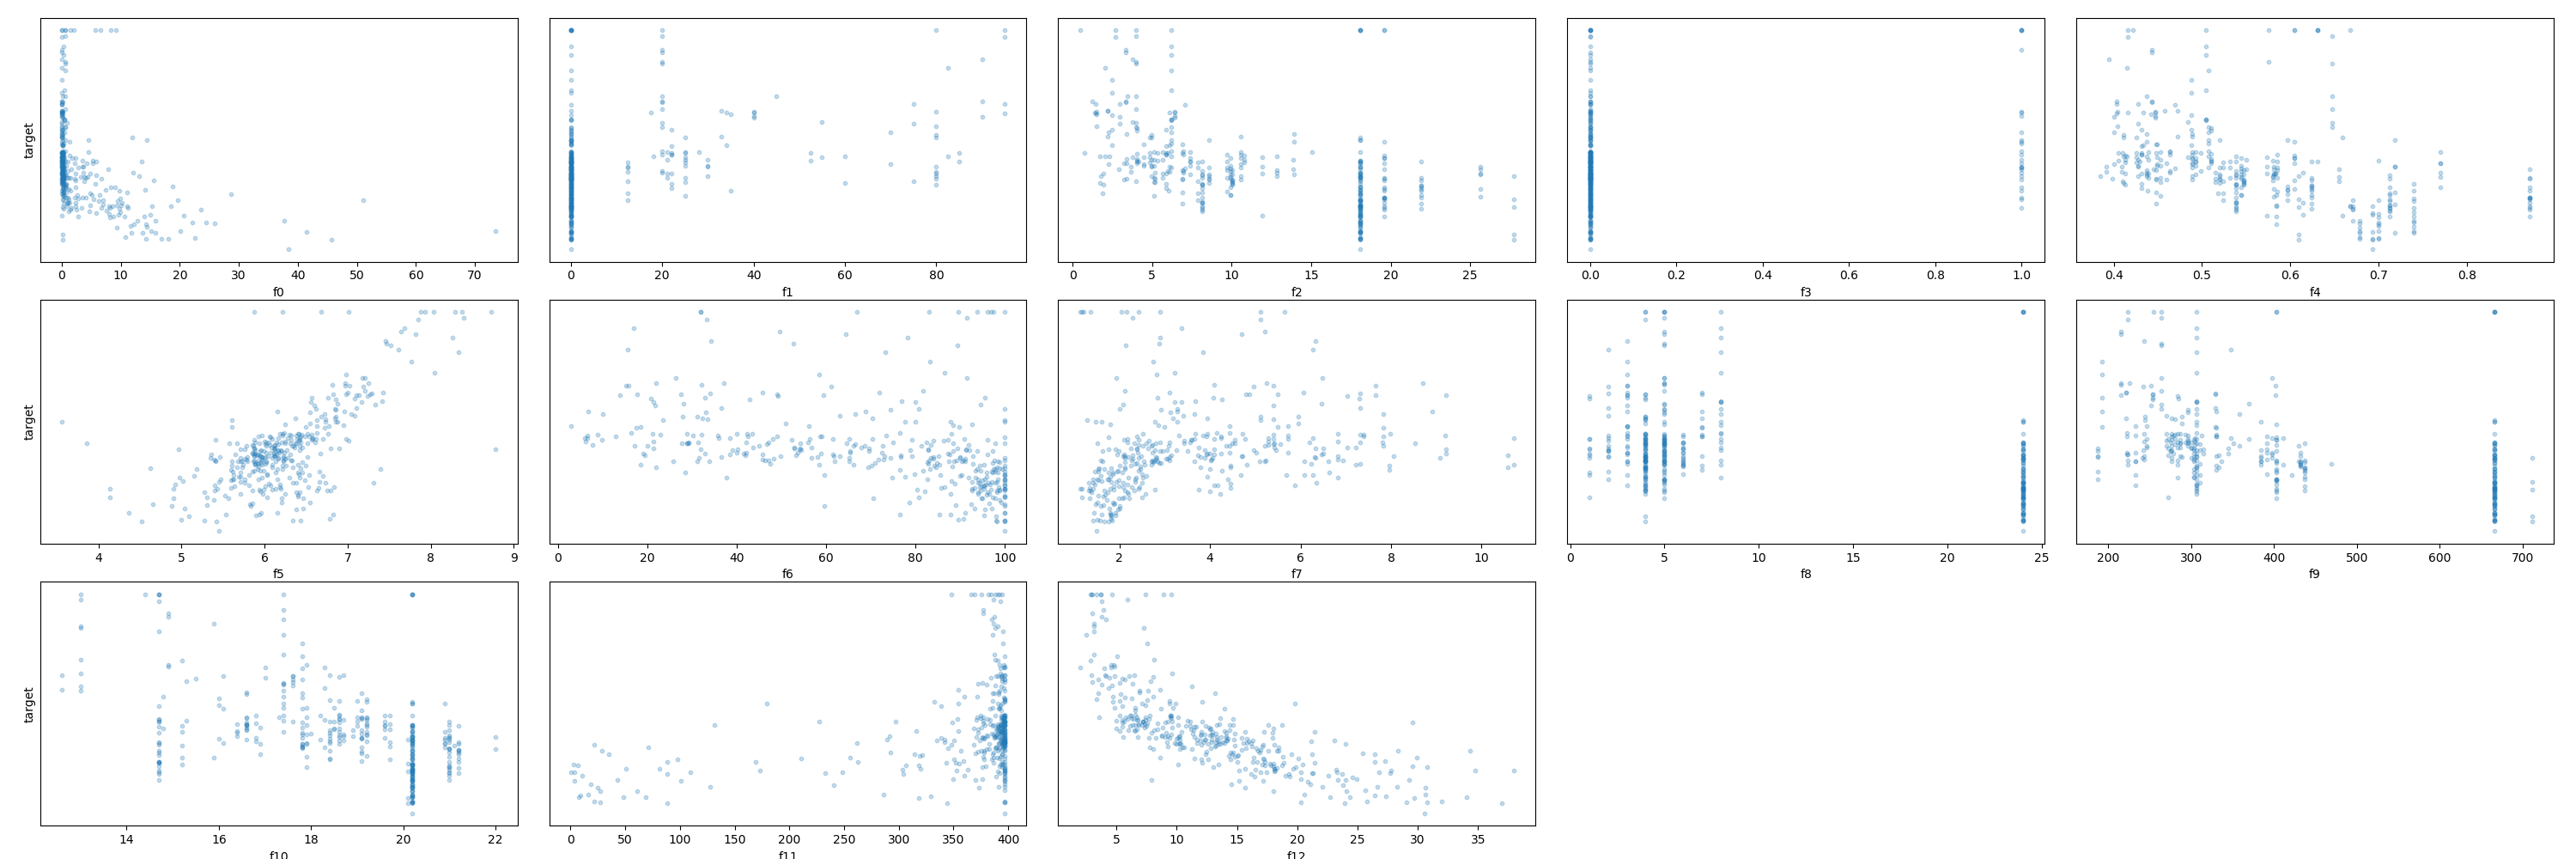

In [0]:
features = train_data.columns[1:]
values = train_data.drop('target').toPandas()
ncols = 5
nrows = math.ceil(len(features) / ncols)

yy = [r['target'] for r in train_data.select('target').collect()]

f, axes = plt.subplots(nrows, ncols, sharey=True, figsize=(30,10))
f.tight_layout()

for irow in range(nrows):
    axes[irow][0].set_ylabel('target')
    for icol in range(ncols):
        try:
            feat = features[irow*ncols + icol]
            xx = values[feat]

            axes[irow][icol].scatter(xx, yy, s=10, alpha=0.25)
            axes[irow][icol].set_xlabel(feat)
            axes[irow][icol].get_yaxis().set_ticks([])
        except IndexError:
            f.delaxes(axes[irow][icol])
display(f)

## Baseline - Spark MLlib Linear Regressor

First, we set a baseline performance by using Linear Regressor in Spark MLlib.

In [0]:
featurizer = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)
lr_train_data = featurizer.transform(train_data)['target', 'features']
lr_test_data = featurizer.transform(test_data)['target', 'features']
display(lr_train_data.limit(10).toPandas())

target,features
5.0,"List(1, 13, List(), List(38.3518, 0.0, 18.1, 0.0, 0.693, 5.453, 100.0, 1.4896, 24.0, 666.0, 20.2, 396.9, 30.59))"
7.0,"List(1, 13, List(), List(0.18337, 0.0, 27.74, 0.0, 0.609, 5.414, 98.3, 1.7554, 4.0, 711.0, 20.1, 344.05, 23.97))"
7.0,"List(1, 13, List(), List(45.7461, 0.0, 18.1, 0.0, 0.693, 4.519, 100.0, 1.6582, 24.0, 666.0, 20.2, 88.27, 36.98))"
7.2,"List(1, 13, List(), List(14.2362, 0.0, 18.1, 0.0, 0.693, 6.343, 100.0, 1.5741, 24.0, 666.0, 20.2, 396.9, 20.32))"
7.2,"List(1, 13, List(), List(16.8118, 0.0, 18.1, 0.0, 0.7, 5.277, 98.1, 1.4261, 24.0, 666.0, 20.2, 396.9, 30.81))"
7.2,"List(1, 13, List(), List(18.0846, 0.0, 18.1, 0.0, 0.679, 6.434, 100.0, 1.8347, 24.0, 666.0, 20.2, 27.25, 29.05))"
7.4,"List(1, 13, List(), List(22.5971, 0.0, 18.1, 0.0, 0.7, 5.0, 89.5, 1.5184, 24.0, 666.0, 20.2, 396.9, 31.99))"
7.5,"List(1, 13, List(), List(10.8342, 0.0, 18.1, 0.0, 0.679, 6.782, 90.8, 1.8195, 24.0, 666.0, 20.2, 21.57, 25.79))"
8.1,"List(1, 13, List(), List(0.20746, 0.0, 27.74, 0.0, 0.609, 5.093, 98.0, 1.8226, 4.0, 711.0, 20.1, 318.43, 29.68))"
8.3,"List(1, 13, List(), List(15.8603, 0.0, 18.1, 0.0, 0.679, 5.896, 95.4, 1.9096, 24.0, 666.0, 20.2, 7.68, 24.39))"


In [0]:
featurizer.transform(train_data).limit(10).toPandas()

,target,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,features
0,5.0,38.35180,0.0,18.10,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,"[38.3518, 0.0, 18.1, 0.0, 0.693, 5.453, 100.0,..."
1,7.0,0.18337,0.0,27.74,0.0,0.609,5.414,98.3,1.7554,4.0,711.0,20.1,344.05,23.97,"[0.18337, 0.0, 27.74, 0.0, 0.609, 5.414, 98.3,..."
2,7.0,45.74610,0.0,18.10,0.0,0.693,4.519,100.0,1.6582,24.0,666.0,20.2,88.27,36.98,"[45.7461, 0.0, 18.1, 0.0, 0.693, 4.519, 100.0,..."
3,7.2,14.23620,0.0,18.10,0.0,0.693,6.343,100.0,1.5741,24.0,666.0,20.2,396.90,20.32,"[14.2362, 0.0, 18.1, 0.0, 0.693, 6.343, 100.0,..."
4,7.2,16.81180,0.0,18.10,0.0,0.700,5.277,98.1,1.4261,24.0,666.0,20.2,396.90,30.81,"[16.8118, 0.0, 18.1, 0.0, 0.7, 5.277, 98.1, 1...."
5,7.2,18.08460,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05,"[18.0846, 0.0, 18.1, 0.0, 0.679, 6.434, 100.0,..."
6,7.4,22.59710,0.0,18.10,0.0,0.700,5.000,89.5,1.5184,24.0,666.0,20.2,396.90,31.99,"[22.5971, 0.0, 18.1, 0.0, 0.7, 5.0, 89.5, 1.51..."
7,7.5,10.83420,0.0,18.10,0.0,0.679,6.782,90.8,1.8195,24.0,666.0,20.2,21.57,25.79,"[10.8342, 0.0, 18.1, 0.0, 0.679, 6.782, 90.8, ..."
8,8.1,0.20746,0.0,27.74,0.0,0.609,5.093,98.0,1.8226,4.0,711.0,20.1,318.43,29.68,"[0.20746, 0.0, 27.74, 0.0, 0.609, 5.093, 98.0,..."
9,8.3,15.86030,0.0,18.10,0.0,0.679,5.896,95.4,1.9096,24.0,666.0,20.2,7.68,24.39,"[15.8603, 0.0, 18.1, 0.0, 0.679, 5.896, 95.4, ..."


In [0]:
# By default, `maxIter` is 100. Other params you may want to change include: `regParam`, `elasticNetParam`, etc.
lr = LinearRegression(
    labelCol='target',
)

lr_model = lr.fit(lr_train_data)
lr_predictions = lr_model.transform(lr_test_data)

display(lr_predictions.limit(10).toPandas())

target,features,prediction
5.0,"List(1, 13, List(), List(67.9208, 0.0, 18.1, 0.0, 0.693, 5.683, 100.0, 1.4254, 24.0, 666.0, 20.2, 384.97, 22.98))",10.840796919767243
5.6,"List(1, 13, List(), List(25.0461, 0.0, 18.1, 0.0, 0.693, 5.987, 100.0, 1.5888, 24.0, 666.0, 20.2, 396.9, 26.77))",13.243210244993406
6.3,"List(1, 13, List(), List(9.91655, 0.0, 18.1, 0.0, 0.693, 5.852, 77.8, 1.5004, 24.0, 666.0, 20.2, 338.16, 29.97))",12.146865627293991
8.3,"List(1, 13, List(), List(24.8017, 0.0, 18.1, 0.0, 0.693, 5.349, 96.0, 1.7028, 24.0, 666.0, 20.2, 396.9, 19.77))",14.471714057928295
8.5,"List(1, 13, List(), List(7.67202, 0.0, 18.1, 0.0, 0.693, 5.747, 98.9, 1.6334, 24.0, 666.0, 20.2, 393.1, 19.92))",17.082658831019074
10.2,"List(1, 13, List(), List(17.8667, 0.0, 18.1, 0.0, 0.671, 6.223, 100.0, 1.3861, 24.0, 666.0, 20.2, 393.74, 21.78))",17.720977215150057
10.4,"List(1, 13, List(), List(88.9762, 0.0, 18.1, 0.0, 0.671, 6.968, 91.9, 1.4165, 24.0, 666.0, 20.2, 396.9, 17.21))",16.741030711114917
11.0,"List(1, 13, List(), List(7.36711, 0.0, 18.1, 0.0, 0.679, 6.193, 78.1, 1.9356, 24.0, 666.0, 20.2, 96.73, 21.52))",14.431770346036018
11.3,"List(1, 13, List(), List(9.18702, 0.0, 18.1, 0.0, 0.7, 5.536, 100.0, 1.5804, 24.0, 666.0, 20.2, 396.9, 23.6))",14.478643032934912
12.7,"List(1, 13, List(), List(13.3598, 0.0, 18.1, 0.0, 0.693, 5.887, 94.7, 1.7821, 24.0, 666.0, 20.2, 396.9, 16.35))",18.653009212866746


We evaluate the prediction result by using `mmlspark.train.ComputeModelStatistics` which returns four metrics:
* [MSE (Mean Squared Error)](https://en.wikipedia.org/wiki/Mean_squared_error)
* [RMSE (Root Mean Squared Error)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) = sqrt(MSE)
* [R quared](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* [MAE (Mean Absolute Error)](https://en.wikipedia.org/wiki/Mean_absolute_error)

In [0]:
metrics = ComputeModelStatistics(
    evaluationMetric='regression',  # какие метрики считать 
    labelCol='target',
    scoresCol='prediction'
).transform(lr_predictions)

results = metrics.toPandas()  # в пандас
results.insert(0, 'model', ['Spark MLlib - Linear Regression'])  # вставляем в пандас
display(results)

model,mean_squared_error,root_mean_squared_error,R^2,mean_absolute_error
Spark MLlib - Linear Regression,27.976319703714434,5.289264571158681,0.7112910017173608,3.715422619606003


## Vowpal Wabbit

Perform VW-style feature hashing. Many types (numbers, string, bool, map of string to (number, string)) are supported.

In [0]:
vw_featurizer = VowpalWabbitFeaturizer(
    inputCols=feature_cols,
    outputCol='features',
)
vw_train_data = vw_featurizer.transform(train_data)['target', 'features']
vw_test_data = vw_featurizer.transform(test_data)['target', 'features']
display(vw_train_data.limit(10).toPandas())

target,features
5.0,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 100.0, 18.1, 1.4896, 666.0, 24.0, 30.59, 5.453, 396.9, 38.3518, 0.693))"
7.0,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.1, 98.3, 27.74, 1.7554, 711.0, 4.0, 23.97, 5.414, 344.05, 0.18337, 0.609))"
7.0,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 100.0, 18.1, 1.6582, 666.0, 24.0, 36.98, 4.519, 88.27, 45.7461, 0.693))"
7.2,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 100.0, 18.1, 1.5741, 666.0, 24.0, 20.32, 6.343, 396.9, 14.2362, 0.693))"
7.2,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 98.1, 18.1, 1.4261, 666.0, 24.0, 30.81, 5.277, 396.9, 16.8118, 0.7))"
7.2,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 100.0, 18.1, 1.8347, 666.0, 24.0, 29.05, 6.434, 27.25, 18.0846, 0.679))"
7.4,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 89.5, 18.1, 1.5184, 666.0, 24.0, 31.99, 5.0, 396.9, 22.5971, 0.7))"
7.5,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 90.8, 18.1, 1.8195, 666.0, 24.0, 25.79, 6.782, 21.57, 10.8342, 0.679))"
8.1,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.1, 98.0, 27.74, 1.8226, 711.0, 4.0, 29.68, 5.093, 318.43, 0.20746, 0.609))"
8.3,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 95.4, 18.1, 1.9096, 666.0, 24.0, 24.39, 5.896, 7.68, 15.8603, 0.679))"


See [VW wiki](https://github.com/vowpalWabbit/vowpal_wabbit/wiki/Command-Line-Arguments) for command line arguments.

In [0]:
# Use the same number of iterations as Spark MLlib's Linear Regression (=100)
args = "--holdout_off --loss_function quantile -l 7 -q :: --power_t 0.3"
vwr = VowpalWabbitRegressor(
    labelCol='target',
    args=args,
    numPasses=100,
)

# To reduce number of partitions (which will effect performance), use `vw_train_data.repartition(1)`
vw_train_data_2 = vw_train_data.repartition(1).cache()
print(vw_train_data_2.count())
vw_model = vwr.fit(vw_train_data_2.repartition(1))
vw_predictions = vw_model.transform(vw_test_data)

display(vw_predictions.limit(10).toPandas())

target,features,rawPrediction,prediction
5.0,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 100.0, 18.1, 1.4254, 666.0, 24.0, 22.98, 5.683, 384.97, 67.9208, 0.693))",20.90886688232422,20.90886688232422
5.6,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 100.0, 18.1, 1.5888, 666.0, 24.0, 26.77, 5.987, 396.9, 25.0461, 0.693))",32.110198974609375,32.110198974609375
6.3,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 77.8, 18.1, 1.5004, 666.0, 24.0, 29.97, 5.852, 338.16, 9.91655, 0.693))",34.4964599609375,34.4964599609375
8.3,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 96.0, 18.1, 1.7028, 666.0, 24.0, 19.77, 5.349, 396.9, 24.8017, 0.693))",33.560638427734375,33.560638427734375
8.5,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 98.9, 18.1, 1.6334, 666.0, 24.0, 19.92, 5.747, 393.1, 7.67202, 0.693))",40.183040618896484,40.183040618896484
10.2,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 100.0, 18.1, 1.3861, 666.0, 24.0, 21.78, 6.223, 393.74, 17.8667, 0.671))",37.640419006347656,37.640419006347656
10.4,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 91.9, 18.1, 1.4165, 666.0, 24.0, 17.21, 6.968, 396.9, 88.9762, 0.671))",23.387290954589844,23.387290954589844
11.0,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 78.1, 18.1, 1.9356, 666.0, 24.0, 21.52, 6.193, 96.73, 7.36711, 0.679))",33.56855010986328,33.56855010986328
11.3,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 100.0, 18.1, 1.5804, 666.0, 24.0, 23.6, 5.536, 396.9, 9.18702, 0.7))",37.96609115600586,37.96609115600586
12.7,"List(0, 1073741824, List(287408178, 419613213, 464140333, 556319843, 584064458, 780495775, 824677867, 851899283, 921728202, 933181289, 1055634727), List(20.2, 94.7, 18.1, 1.7821, 666.0, 24.0, 16.35, 5.887, 396.9, 13.3598, 0.693))",39.88002014160156,39.88002014160156


In [0]:
metrics = ComputeModelStatistics(
    evaluationMetric='regression',
    labelCol='target',
    scoresCol='prediction'
).transform(vw_predictions)

vw_result = metrics.toPandas()
vw_result.insert(0, 'model', ['Vowpal Wabbit'])
results = results.append(
    vw_result,
    ignore_index=True
)
display(results)

model,mean_squared_error,root_mean_squared_error,R^2,mean_absolute_error
Spark MLlib - Linear Regression,27.976319703714434,5.289264571158681,0.7112910017173608,3.715422619606003
Vowpal Wabbit,261.6089180538872,16.174328983110463,-1.6997421202301588,14.759180039398432


## LightGBM

In [0]:
lgr = LightGBMRegressor(
    objective='quantile',
    alpha=0.2,
    learningRate=0.3,
    numLeaves=31,
    labelCol='target',
    numIterations=100,
)

# Using one partition since the training dataset is very small
repartitioned_data = lr_train_data.repartition(1).cache()
print(repartitioned_data.count())
lg_model = lgr.fit(repartitioned_data)  # не работает этот кусок
lg_predictions = lg_model.transform(lr_test_data)

display(lg_predictions.limit(10).toPandas())

377

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-1232268167943580> in <module> () 
 11 repartitioned_data = lr_train_data . repartition ( 1 ) . cache ( ) 
 12 print ( repartitioned_data . count ( ) ) 
 ---> 13 lg_model = lgr . fit ( repartitioned_data ) 
 14 lg_predictions = lg_model . transform ( lr_test_data ) 
 15 

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 130 return self . copy ( params ) . _fit ( dataset ) 
 131 else : 
 --> 132 return self . _fit ( dataset ) 
 133 else : 
 134 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit (self, dataset) 
 293 
 294 def _fit ( self , dataset ) : 
 --> 295 java_model = self . _fit_java ( dataset ) 
 296 model = self . _create_model ( java_model ) 
 297 return self . _copyValues ( model ) 

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit_java (self, dataset) 
 290 """
 291 self . _transfer_params_to_java ( ) 
 --> 292 return self . _java_obj . fit ( dataset . _jdf ) 
 293 
 294 def _fit ( self , dataset ) : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1255 answer = self . gateway_client . send_command ( command ) 
 1256 return_value = get_return_value(
 -> 1257 answer, self.gateway_client, self.target_id, self.name)
 1258 
 1259 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 61 def deco ( * a , ** kw ) : 
 62 try : 
 ---> 63 return f ( * a , ** kw ) 
 64 except py4j . protocol . Py4JJavaError as e : 
 65 s = e . java_exception . toString ( ) 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling o1280.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 301.0 failed 1 times, most recent failure: Lost task 0.0 in stage 301.0 (TID 1280, localhost, executor driver): java.lang.Exception: Dataset create call failed in LightGBM with error: Feature (Column_) appears more than one time.
	at com.microsoft.ml.spark.lightgbm.LightGBMUtils$.validate(LightGBMUtils.scala:30)
	at com.microsoft.ml.spark.lightgbm.LightGBMUtils$.generateDenseDataset(LightGBMUtils.scala:227)
	at com.microsoft.ml.spark.lightgbm.TrainUtils$.generateDataset(TrainUtils.scala:42)
	at com.microsoft.ml.spark.lightgbm.TrainUtils$.translate(TrainUtils.scala:377)
	at com.microsoft.ml.spark.lightgbm.TrainUtils$.trainLightGBM(TrainUtils.scala:565)
	at com.microsoft.ml.spark.lightgbm.LightGBMBase$$anonfun$7.apply(LightGBMBase.scala:225)
	at com.microsoft.ml.spark.lightgbm.LightGBMBase$$anonfun$7.apply(LightGBMBase.scala:225)
	at org.apache.spark.sql.execution.MapPartitionsExec$$anonfun$5.apply(objects.scala:200)
	at org.apache.spark.sql.execution.MapPartitionsExec$$anonfun$5.apply(objects.scala:197)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:852)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:852)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:60)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:340)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:304)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:60)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:340)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:304)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.doRunTask(Task.scala:139)
	at org.apache.spark.scheduler.Task.run(Task.scala:112)
	at org.apache.spa

In [0]:
metrics = ComputeModelStatistics(
    evaluationMetric='regression',
    labelCol='target',
    scoresCol='prediction'
).transform(lg_predictions)

lg_result = metrics.toPandas()
lg_result.insert(0, 'model', ['LightGBM'])
results = results.append(
    lg_result,
    ignore_index=True
)
display(results)

Following figure shows the actual-vs.-prediction graphs of the results:

<img width="1102" alt="lr-vw-lg" src="https://user-images.githubusercontent.com/42475935/64071975-4c3e9600-cc54-11e9-8b1f-9a1ee300f445.png">

In [0]:
cmap = get_cmap('YlOrRd')

target = np.array(test_data.select('target').collect()).flatten()
model_preds = [
    ("Spark MLlib Linear Regression", lr_predictions),
    ("Vowpal Wabbit", vw_predictions),
    ("LightGBM", lg_predictions)
]

f, axes = plt.subplots(1, len(model_preds), sharey=True, figsize=(18, 6))
f.tight_layout()

for i, (model_name, preds) in enumerate(model_preds):
    preds = np.array(preds.select('prediction').collect()).flatten()
    err = np.absolute(preds - target)

    norm = Normalize()
    clrs = cmap(np.asarray(norm(err)))[:, :-1]
    axes[i].scatter(preds, target, s=60, c=clrs, edgecolors='#888888', alpha=0.75)
    axes[i].plot((0, 60), (0, 60), linestyle='--', color='#888888')
    axes[i].set_xlabel('Predicted values')
    if i ==0:
        axes[i].set_ylabel('Actual values')
    axes[i].set_title(model_name)